# <center>Welcome to oLIMpus Tutorial #4!</center>
### <center>By S. Libanore</center>
oLIMpus is a fully analytical effective model to study LIM auto- and cross- power spectra durning the EoR. 

Our work builds on the 21-cm effective model presented in Zeus21 (Munoz 2023), which is contained as a submodule of our package.
The reionization module is introduced in Sklansky et al. 2025 (In preparation), and for now is in beta-testing.

#### In this notebook you will learn how to...
- run maps of 21cm and star forming lines during the EoR
- compute the Pearson coefficient to study the evolution of the EoR (see Libanore et al. 2025, arXiv:2509.08886)

## Import the modules you need

In [23]:
import sys
sys.path.append('../EoR_anticorrorelation')
import study_anticorr as s 
from pearson_estimator import zvals
from oLIMpus.analysis import colors
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np 
import os

## Run maps

First of all, define the properties of the maps that you want to use.
Note that using a larger number of cells will require more running time.

In [10]:
Lbox = 250 # box size
Nbox = 50 # number of cells
with_SN = True # introduce shot noise in the map
seed = 3 # random seed to produce the fluctuation field
save_maps = False # if True, it saves one slice of the T21, OIII, xHII coeval boxes 

model = 'OIII' # which line you want to work with
which_par = 'fiducial' # keep the fiducial set of parameters
par_vals = [0] # keep the fiducial set of parameters

Run the maps. Quantitities that are not defined in the previous cell are related with the reionization module, and we recommend to keep them to default since they are still under development.

In [11]:
# this function will produce all the quantities you need
s.run_and_save_model(model=model,
                     which_par=which_par,
                     par_vals=par_vals,
                     Lbox=Lbox,
                     with_shotnoise=with_SN,
                     Nbox=Nbox,
                     save_maps=save_maps, 
                     _R = None,
                     Rmin_bubbles=0.05,
                     compute_mass_weighted_xHII=False,compute_include_partlion=True,compute_partial_and_massweighted=False, extra_label='',
                     seed_input=None, 
                     reionization_by_z = False)

  0%|          | 0/1 [00:00<?, ?it/s]/mnt/DATA/coding/21cm/oLIMpus/Tutorials/../EoR_anticorrorelation/study_anticorr.py:432: RuntimeWarning: invalid value encountered in divide
  r = use_pk_cross/np.sqrt(use_pk_auto_line*use_pk_auto_21)
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 1/1 [01:28<00:00, 88.88s/it]


# Explore the function outputs

The previous function stored, as function of redshift:
- the 21-cm global signal
- the xHII ionization fraction
- the Person coefficient
- the 21-cm, line and cross correlation power spectra (not used in this tutorial)
- the cross correlation coefficient (not used in this tutorial)

Let's plot the global signal, ionization fraction and Pearson coefficient.

In [34]:
def plot_EoR_evolution(Lbox, Nbox, with_shotnoise, model, which_par, par_vals, save_fig):

    output = s.import_model(model,which_par,par_vals,Lbox,with_shotnoise,Nbox)

    # get the global signal 
    T21 = output['T21']

    # get the ionization fraction
    xHII = output['xHv']
    # interpolate xHII in z to compute to which z corresponds a certain xHII
    zxHII = s.interp1d(xHII[0], zvals, bounds_error=False, fill_value=0.)

    # get the Pearson coefficient
    p = output['p']
    # remove nans from the array
    for i in range(len(p[0])):
        if np.isnan(p[0][i]):
            p[0][i] = (p[0][i+1]+p[0][i-1])/2.


    fig, ax = plt.subplots(1,3,figsize=(9.5,3.5))

    plt.rcParams.update({
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
    })

    # plot the global signal
    ax[0].plot(zvals,T21[0],color=colors[0],)

    # plot the ionized fraction
    ax[1].plot(zvals,1-xHII[0],color=colors[0],)

    # plot the Pearson coefficient
    ax[2].plot(zvals,p[0],color=colors[0],)

    # in each panel, add a gray band to indicate where xHII is between 1% and 10%
    xHIImin = 0.01
    xHIImax = 0.1

    for j in range(len(ax)):
        ax[j].axvspan(zxHII(1-xHIImin), zxHII(1-xHIImax),color=colors[0], alpha=0.2,label=r'$\bar{x}_{\rm HII}\in [%g$'%(100*xHIImin) + r'$\%,$' + r'$%g$'%(100*xHIImax) + r'$\%]$')

    # set plot limits and labels
    xmin_plot = 5.5
    xmax_plot = 20
    for j in range(len(ax)):
        ax[j].axhline(0.,linewidth=0.5,color=colors[0])
        ax[j].set_xlim(xmin_plot,xmax_plot)
        ax[j].set_xlabel(r'$z$',fontsize=15)

        handles, labels = ax[j].get_legend_handles_labels()

    ax[1].set_ylim(-.05,1.05)
    ax[2].set_ylim(-1.05,1.05)

    ax[0].set_ylabel(r'$\bar{T}_{21}(z)$',fontsize=15)
    ax[1].set_ylabel(r'$\bar{x}_{\rm HII}(z)$',fontsize=15)
    ax[2].set_ylabel(r'$P(z)$',fontsize=15)

    ax[0].set_title(r'${\rm Global\,Signal}$',fontsize=15)
    ax[1].set_title(r'${\rm Ionized\,Fraction}$',fontsize=15)
    ax[2].set_title(r'${\rm %s}\times T_{21}$'%model,fontsize=15)

    # set legend 
    custom_patch = Patch(facecolor=colors[0], alpha=0.2, label=r'$\bar{x}_{\rm HII}\in [%g$'%(100*xHIImin) + r'$\%,$' + r'$%g$'%(100*xHIImax) + r'$\%]$')

    ax[0].legend(
        handles=handles.insert(1,custom_patch),
        loc=3,
        handlelength=1.15,     
        handleheight=0.6,     
        handletextpad=0.4,    
        borderpad=0.3,
        labelspacing=0.3,
        fontsize=13
    )

    ax[1].legend(
        handles=handles.insert(1, custom_patch),
        loc=1, 
        handlelength=1.15,
        handleheight=0.6,
        handletextpad=0.4,
        borderpad=0.3,
        labelspacing=0.3,
        fontsize=13
    )

    ax[2].legend(
        handles=handles.insert(1, custom_patch),
        loc=3,  
        handlelength=1.15,
        handleheight=0.6,
        handletextpad=0.4,
        borderpad=0.3,
        labelspacing=0.3,
        fontsize=13
            )

    # Adjust layout to make room for the legend
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)

    # save figure if required
    if save_fig:
        SNlabel = '_noSN' if not with_shotnoise else ''
        plot_path = './plots_EoR/'
        if not os.path.exists(plot_path):
            os.makedirs(plot_path, exist_ok=True)
        plt.savefig(plot_path + 'evolution_' + str(Lbox) + '_bar' + SNlabel + '.png',dpi=300,bbox_inches='tight')

    plt.show()

    return 

Successfully loaded model output from ./runs/OIII_fiducial_250_50.pkl


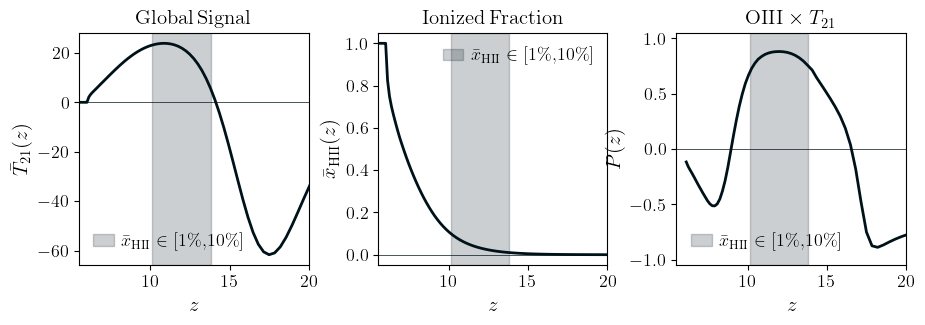

In [35]:
plot_EoR_evolution(Lbox=Lbox, Nbox=Nbox, with_shotnoise=with_SN, model=model, which_par=which_par, par_vals=par_vals, save_fig=False)